In [1]:
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy,copy
from myDataset import PalmNutriDataset
import matplotlib.pyplot as plt
import numpy as np
import pickle
sample_set = 'k17'
target = 'k'

plt.style.use('seaborn-whitegrid')

to_do = [('alex',       f'alexnet_{sample_set}/alex_{sample_set}'),
         ('mobilenet',  f'mobilenet_{sample_set}/mobilenet_{sample_set}'),
         ('resnext',    f'resnext_{sample_set}/resnext_{sample_set}')
         ]

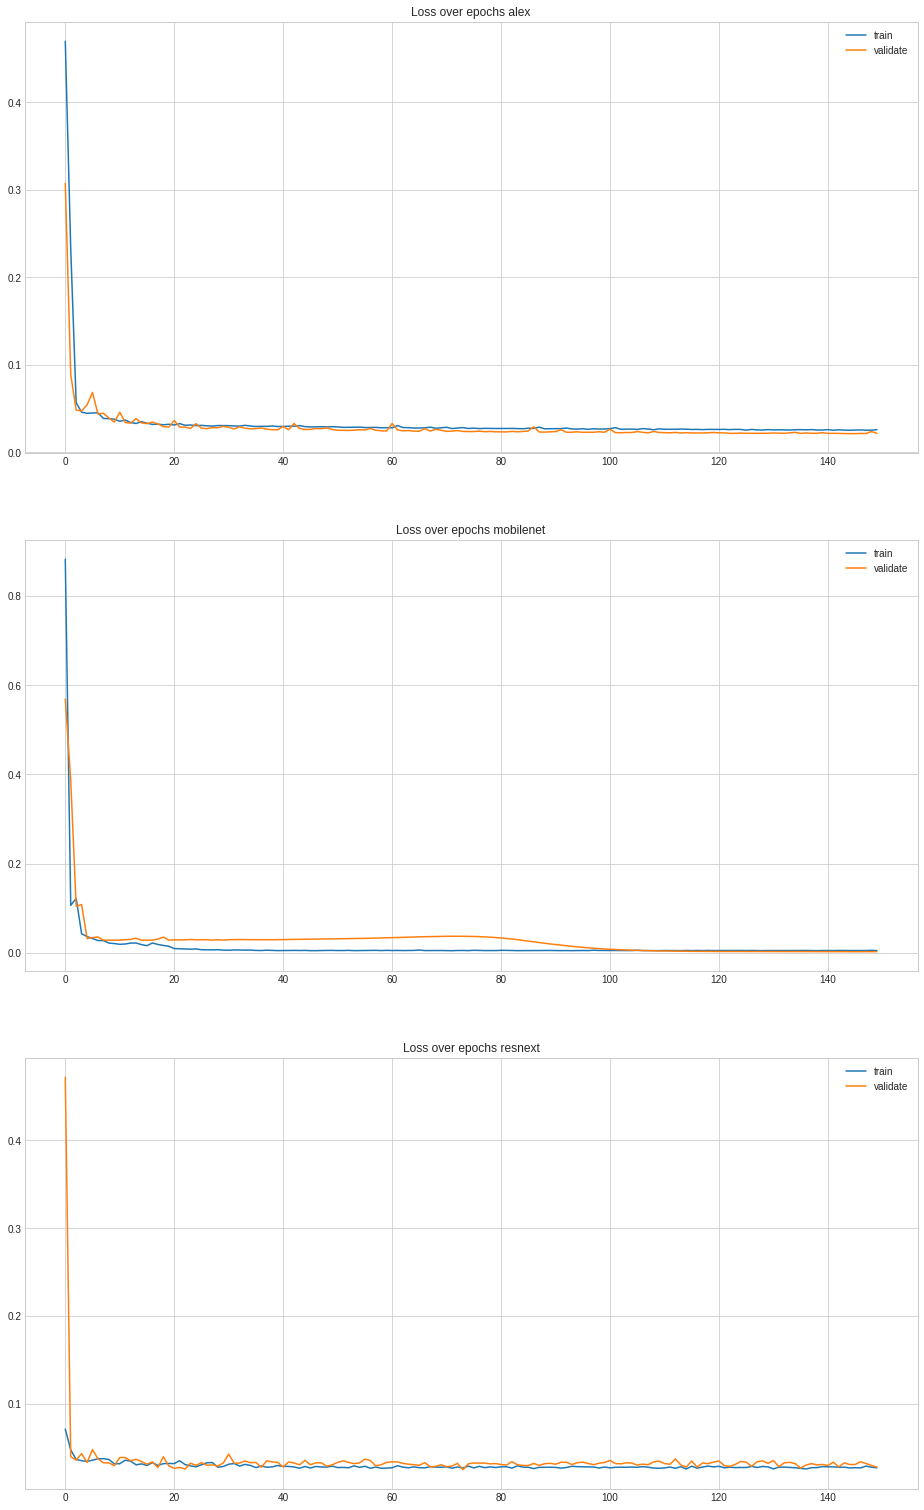

In [2]:
# Plot training result
fig,ax = plt.subplots(nrows=3, figsize=(16,9*3))
for index, (name, path) in enumerate(to_do):
    train_loss = pickle.load(open(f'{path}_train_loss.txt', 'rb'))
    val_loss = pickle.load(open(f'{path}_val_loss.txt', 'rb'))
    ax[index].set_title(f'Loss over epochs {name}')
    ax[index].plot(train_loss, label='train')
    ax[index].plot(val_loss, label='validate')
    ax[index].legend()
plt.show()

del(val_loss)
del(train_loss)

In [3]:
# the magic number
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

preprocess_augment = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

preprocess = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

ground_truth = 'dataset/gt.csv'
full_dataset = PalmNutriDataset(ground_truth=ground_truth, img_dir='dataset', sample_set=sample_set,target=target)
full_dataset.transform = preprocess
print(len(full_dataset))

BATCH_SIZE=64
NUM_WORKERS=2
dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH_SIZE,shuffle=True , num_workers=NUM_WORKERS)

900


In [4]:
def load_model(name, pretrain=None):
    model = None
    if(name == 'alex'):
        model = models.alexnet()
        model.classifier[6] = torch.nn.Linear(in_features=4096,out_features=1,bias=True)
    elif(name == 'mobilenet'):
        model = models.mobilenet_v3_large()
        model.classifier[3] = torch.nn.Linear(in_features=1280,out_features=1,bias=True)
    elif(name == 'resnext'):
        model = models.resnext50_32x4d()
        model.fc = torch.nn.Linear(in_features=2048,out_features=1,bias=True)
    else:
        raise ValueError(f"name:{name} is not defined")

    if(pretrain!=None):
        model.load_state_dict(torch.load(pretrain, map_location='cpu'))
    return model

import math
def get_class(score, target):
    if(target == 'n'):
        n_range = [0,2,2.4,3,math.inf]
        if(score < 2):
            return 1
        if(score < 2.4):
            return 2
        if(score < 3):
            return 3
        else: return 4
    elif(target == 'k'):
        k_range = [0,0.75,0.90,1.2,math.inf]
        if(score < .75):
            return 1
        if(score < .9):
            return 2
        if(score < 1.2):
            return 3
        else: return 4
    else:
        raise ValueError(f"target:{target} is incorrect")


def predict(model, dataloader, device='cpu'):
    all_preds = None
    all_labels = None
    model.to(device)
    with torch.no_grad():
        for index, (inputs,labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1,1)
            # print(inputs,labels)
            preds = model(inputs)
            if(all_preds == None):
                all_preds = preds.cpu().view(-1)
                all_labels = labels.cpu().view(-1)
            else:
                all_preds = torch.cat( [all_preds,preds.cpu().view(-1)],dim=0)
                all_labels = torch.cat( [all_labels,labels.cpu().view(-1)],dim=0)

    return all_preds, all_labels

def print_performance(all_preds, all_labels, target):
    acc = 0
    acc_class = dict()
    len_class = dict()
    err = 0
    err_class = dict()
    # class_3 = []
    for idx in range(len(all_preds)):
        # get class
        pred,label = all_preds[idx], all_labels[idx]
        class_pred = get_class(pred, target)
        class_act = get_class(label, target)
        
        # init if unseen class
        if(class_act not in len_class.keys()):
            acc_class[class_act] = 0
            err_class[class_act] = 0
            len_class[class_act] = 1

        # Check result
        if(class_act == class_pred):
            acc += 1
            acc_class[class_act] += 1
        len_class[class_act] += 1
        err += abs(pred - label)
        err_class[class_act] += abs(pred - label)
        # if(class_act == 3 and class_pred != 3):
        #     class_3.append((full_dataset.filenames[idx],pred,label))

    print('Over All acc: ',acc/len(all_preds) * 100)
    print('Over All err: ',err/len(all_preds))

    for k,v in acc_class.items():
        print(f"Acc of Class {k}: {v}/{len_class[k]} = {v/len_class[k] * 100}")
        print(f"Err of Class {k}: {err_class[k]/len_class[k]}")


alex alexnet_k17/alex_k17
Over All acc:  56.333333333333336
Over All err:  tensor(0.1212)
Acc of Class 3: 1/137 = 0.7299270072992701
Err of Class 3: 0.2267710417509079
Acc of Class 2: 123/249 = 49.39759036144578
Err of Class 2: 0.0802793949842453
Acc of Class 1: 383/508 = 75.39370078740157
Err of Class 1: 0.10428659617900848
Acc of Class 4: 0/10 = 0.0
Err of Class 4: 0.5074208974838257

mobilenet mobilenet_k17/mobilenet_k17
Over All acc:  76.77777777777777
Over All err:  tensor(0.0601)
Acc of Class 1: 441/508 = 86.81102362204724
Err of Class 1: 0.0595814548432827
Acc of Class 2: 156/249 = 62.65060240963856
Err of Class 2: 0.05189424753189087
Acc of Class 3: 92/137 = 67.15328467153284
Err of Class 3: 0.06940627843141556
Acc of Class 4: 2/10 = 20.0
Err of Class 4: 0.13956114649772644

resnext resnext_k17/resnext_k17
Over All acc:  56.666666666666664
Over All err:  tensor(0.1263)
Acc of Class 1: 382/508 = 75.19685039370079
Err of Class 1: 0.10789044946432114
Acc of Class 2: 101/249 = 40.5

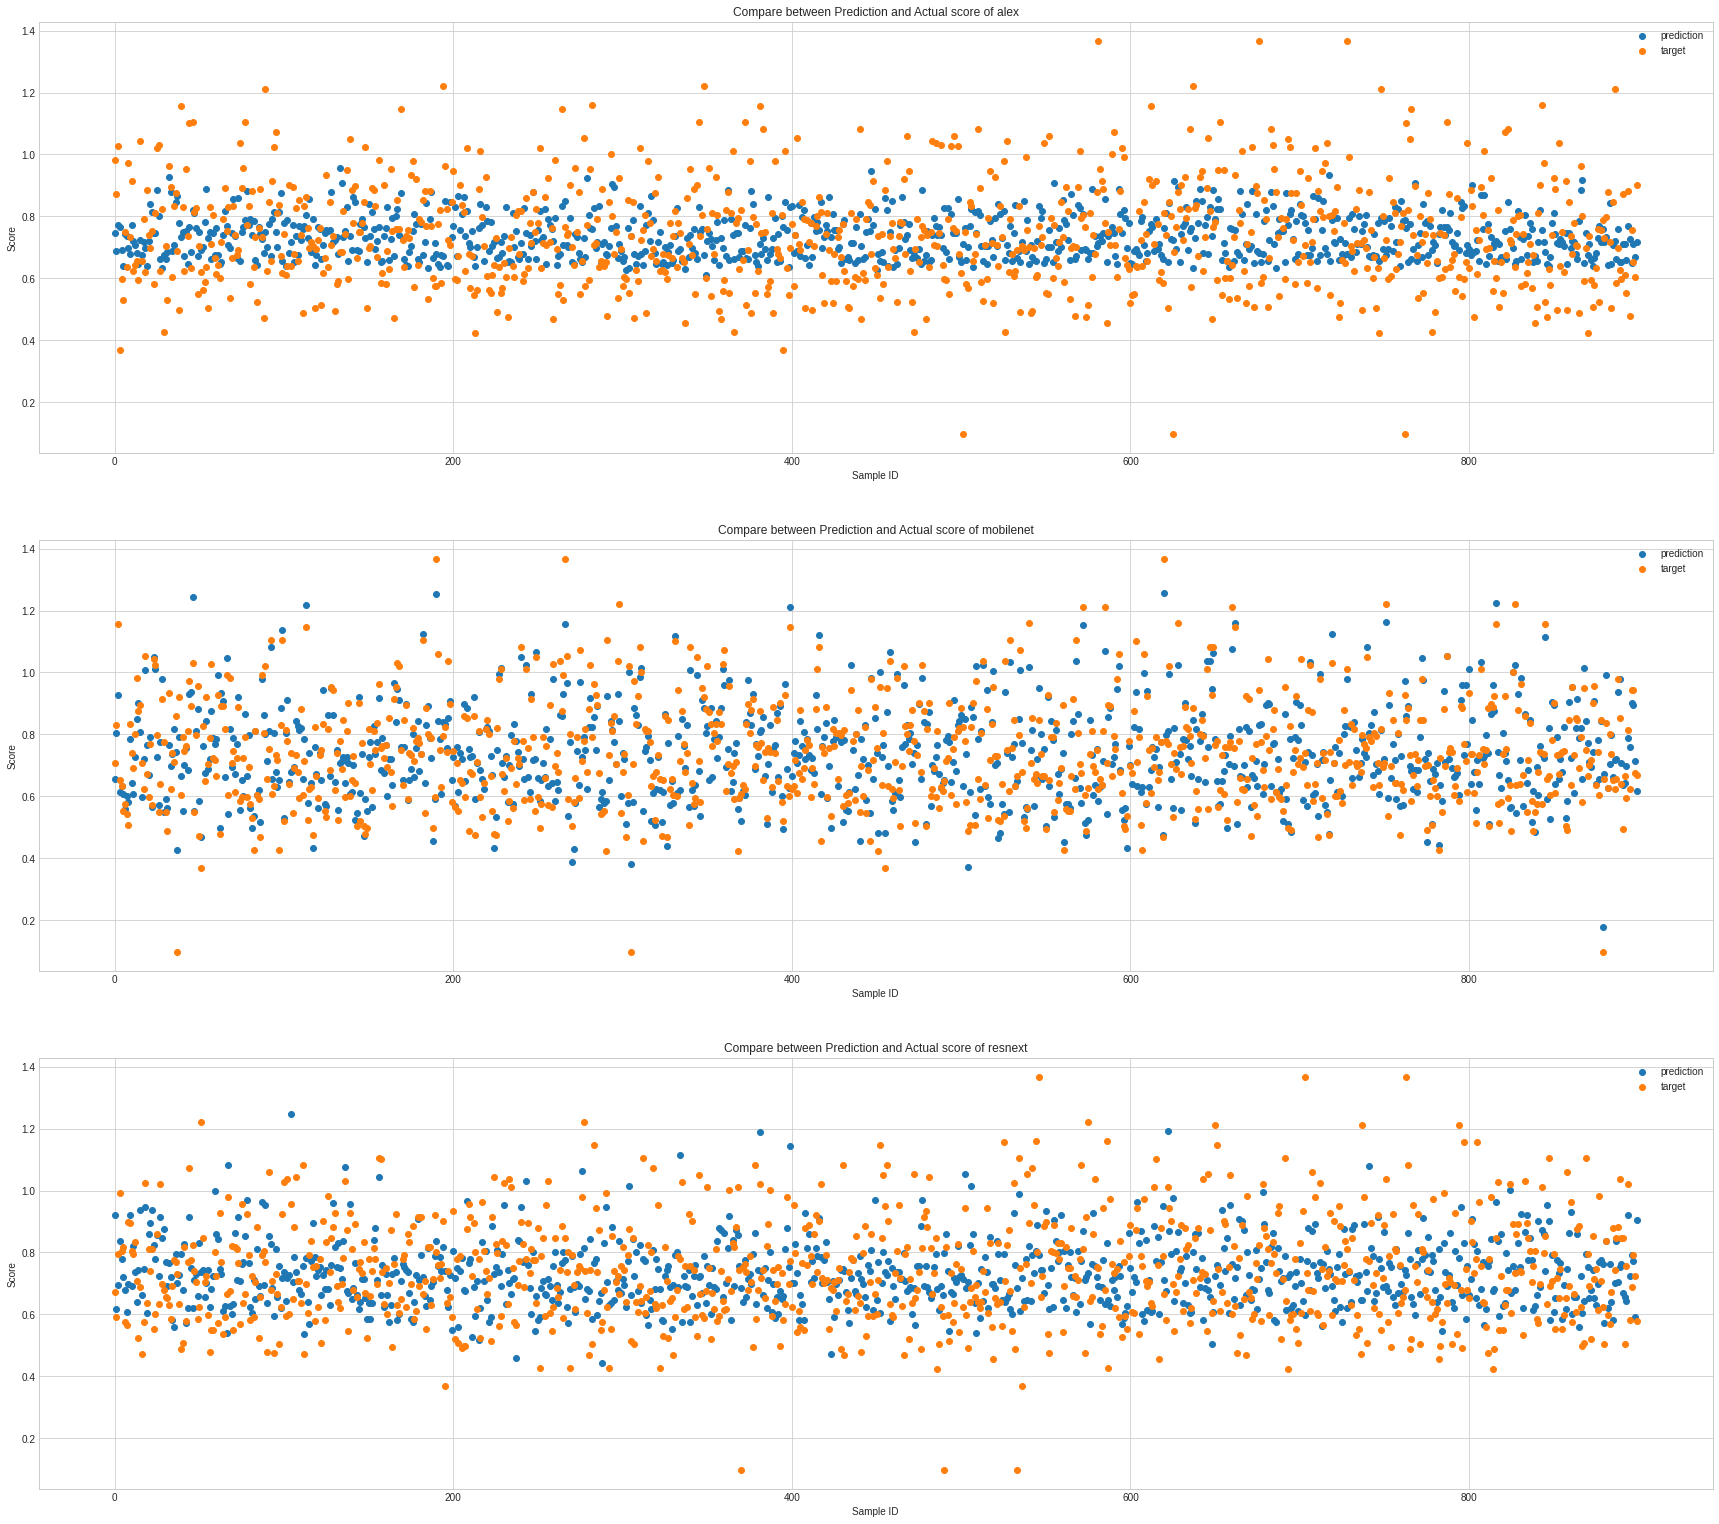

In [5]:
preds_of = dict()
labels_of = dict()
fig,ax = plt.subplots(3, figsize=(30,9*3))
for index, (name, weight) in enumerate(to_do):
    print(name, weight)
    print('='*20)
    model = load_model(name, f'{weight}.pth')
    all_preds, all_labels = predict(model, dataloader, 'cuda:0')
    preds_of[name] = all_preds
    labels_of[name] = all_labels
    ax[index].scatter(np.arange(len(all_preds)),all_preds,label='prediction')
    ax[index].scatter(np.arange(len(all_labels)),all_labels,label='target')
    ax[index].set_title(f'Compare between Prediction and Actual score of {name}')
    ax[index].set_ylabel('Score')
    ax[index].set_xlabel('Sample ID')
    ax[index].legend()
    print_performance(all_preds, all_labels, target)
    print()

plt.show()
del(model)

Top 5 Error example from [alex]
Filename:K304_17_1.JPG
Score Label:0.09799999743700027|Pred:0.7230013012886047|diff=0.6250013113021851
Class Label:1|Pred:1


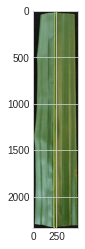

Filename:K179_17_1.JPG
Score Label:0.09799999743700027|Pred:0.7887872457504272|diff=0.6907872557640076
Class Label:1|Pred:2


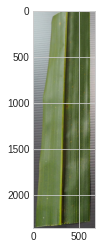

Filename:K234_17_5.JPG
Score Label:1.3660000562667847|Pred:0.68232661485672|diff=0.6836734414100647
Class Label:4|Pred:1


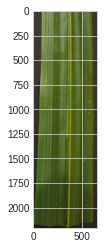

Filename:K405_17_1.JPG
Score Label:1.3660000562667847|Pred:0.7130826711654663|diff=0.6529173851013184
Class Label:4|Pred:1


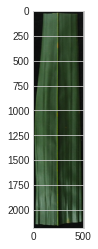

Filename:K267_17_1.JPG
Score Label:1.3660000562667847|Pred:0.6786549091339111|diff=0.6873451471328735
Class Label:4|Pred:1


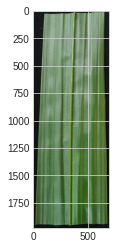

Top 5 Error example from [mobilenet]
Filename:K68_17_5.JPG
Score Label:0.7149999737739563|Pred:0.9587330222129822|diff=0.24373304843902588
Class Label:1|Pred:3


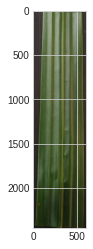

Filename:K431_17_1.JPG
Score Label:0.4869999885559082|Pred:0.7530472278594971|diff=0.26604723930358887
Class Label:1|Pred:2


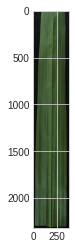

Filename:K310_17_2.JPG
Score Label:1.2209999561309814|Pred:0.8427008390426636|diff=0.37829911708831787
Class Label:4|Pred:2


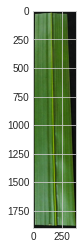

Filename:K428_17_2.JPG
Score Label:0.09799999743700027|Pred:0.42723557353019714|diff=0.32923558354377747
Class Label:1|Pred:1


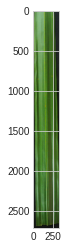

Filename:K377_17_2.JPG
Score Label:0.09799999743700027|Pred:0.3818054497241974|diff=0.2838054597377777
Class Label:1|Pred:1


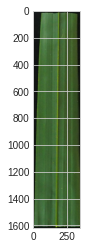

Top 5 Error example from [resnext]
Filename:K413_17_3.JPG
Score Label:0.09799999743700027|Pred:0.6861609816551208|diff=0.5881609916687012
Class Label:1|Pred:1


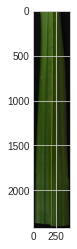

Filename:K233_17_3.JPG
Score Label:0.09799999743700027|Pred:0.6865789890289307|diff=0.588578999042511
Class Label:1|Pred:1


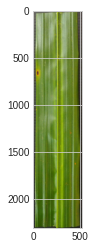

Filename:K265_17_4.JPG
Score Label:1.3660000562667847|Pred:0.7278531789779663|diff=0.6381468772888184
Class Label:4|Pred:1


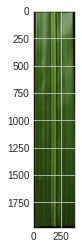

Filename:K231_17_2.JPG
Score Label:1.3660000562667847|Pred:0.5972855091094971|diff=0.7687145471572876
Class Label:4|Pred:1


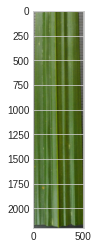

Filename:K44_17_5.JPG
Score Label:0.09799999743700027|Pred:0.7992905974388123|diff=0.7012906074523926
Class Label:1|Pred:2


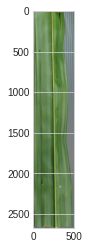

In [6]:
import matplotlib.image as mpimg

for name,_ in to_do:
    print(f"Top 5 Error example from [{name}]")
    print("="*20)
    preds = preds_of[name]
    labels = labels_of[name]
    errors = abs(preds - labels).numpy()
    # get top 5 error  
    idxs = np.argpartition(errors, -5)[-5:]
    for idx in idxs:
        filename = full_dataset.filenames[idx]
        pred = preds[idx]
        label = labels[idx]
        print(f"Filename:{filename}")
        print(f"Score Label:{label}|Pred:{pred}|diff={abs(label-pred)}")
        print(f"Class Label:{get_class(label,target)}|Pred:{get_class(pred,target)}")
        img = mpimg.imread(f'dataset/{sample_set}/{filename}')
        plt.imshow(img)
        plt.show()